<h1>Transfer Learning on Flowers dataset from Tensorflow Datasets

In [0]:
import tensorflow as tf

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_hub as hub


In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
(training_set , testing_set) , dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]','train[70%:]'], #split into 70:30 for train and test
    as_supervised=True,
    with_info=True       
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [5]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [6]:
print(dataset_info.features['label'])

ClassLabel(shape=(), dtype=tf.int64, num_classes=5)


In [7]:
num_classes = 5

num_training_examples = 0
num_validation_examples = 0
validation_set = testing_set
for example in training_set :
  num_training_examples +=1
for example in validation_set :
  num_validation_examples +=1
print(num_training_examples)  
print(num_validation_examples)


2569
1101


In [8]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [9]:
for i,example in enumerate(training_set.take(5)):
  print(example[0].shape , example[1])

#shapes are different so we need to normalize  

(333, 500, 3) tf.Tensor(2, shape=(), dtype=int64)
(212, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
(240, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
(240, 320, 3) tf.Tensor(4, shape=(), dtype=int64)
(317, 500, 3) tf.Tensor(3, shape=(), dtype=int64)


MOBILENET v2 requires (224 , 224 ) resolution input so normalizing them


In [0]:
IMAGE_RES = 224 

def format_image(image , label):
  image = tf.image.resize(image , (IMAGE_RES , IMAGE_RES))/25
  return image , label

batch_size = 32


In [0]:
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(32).prefetch(1)

validation_batches = validation_set.map(format_image).batch(32).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [0]:
feature_extractor.trainable = False

In [0]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(num_classes)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 7s 90ms/step - loss: 1.2781 - accuracy: 0.4838 - val_loss: 1.0102 - val_accuracy: 0.6067
Epoch 2/10
81/81 [==============================] - 6s 76ms/step - loss: 0.9057 - accuracy: 0.6730 - val_loss: 0.8694 - val_accuracy: 0.6985
Epoch 3/10
81/81 [==============================] - 6s 78ms/step - loss: 0.7856 - accuracy: 0.7221 - val_loss: 0.8364 - val_accuracy: 0.6930
Epoch 4/10
81/81 [==============================] - 6s 77ms/step - loss: 0.7073 - accuracy: 0.7528 - val_loss: 0.7934 - val_accuracy: 0.7166
Epoch 5/10
81/81 [==============================] - 6s 77ms/step - loss: 0.6608 - accuracy: 0.7699 - val_loss: 0.7826 - val_accuracy: 0.7248
Epoch 6/10
81/81 [==============================] - 6s 78ms/step - loss: 0.6168 - accuracy: 0.7847 - val_loss: 0.7676 - val_accuracy: 0.7139
Epoch 7/10
81/81 [==============================] - 6s 78ms/step - loss: 0.5801 - accuracy: 0.7984 - val_loss: 0.7531 - val_accuracy: 0.7239
Epoch 8/10
81

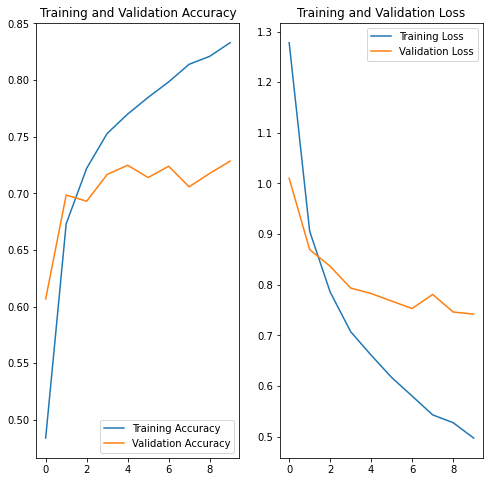

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [19]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['roses' 'sunflowers' 'roses' 'dandelion' 'sunflowers' 'sunflowers'
 'tulips' 'roses' 'dandelion' 'daisy' 'roses' 'sunflowers' 'tulips'
 'dandelion' 'dandelion' 'dandelion' 'daisy' 'dandelion' 'daisy'
 'dandelion' 'tulips' 'tulips' 'tulips' 'daisy' 'dandelion' 'sunflowers'
 'tulips' 'tulips' 'sunflowers' 'tulips' 'sunflowers' 'dandelion']


In [20]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [4 3 4 0 4 3 2 4 0 0 4 3 2 0 0 0 1 0 1 0 2 0 2 1 0 3 2 2 3 2 3 0]
Predicted labels:  [4 3 4 0 3 3 2 4 0 1 4 3 2 0 0 0 1 0 1 0 2 2 2 1 0 3 2 2 3 2 3 0]


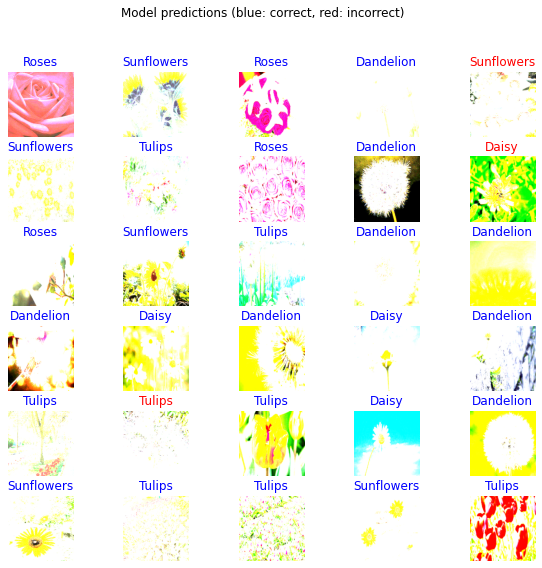

In [21]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

Trying with inception V3 model


In [23]:
IMAGE_RES = 299
BATCH_SIZE = 32
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [24]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 19s 232ms/step - loss: 1.5189 - accuracy: 0.3546 - val_loss: 1.4467 - val_accuracy: 0.4015
Epoch 2/6
81/81 [==============================] - 15s 186ms/step - loss: 1.3115 - accuracy: 0.4726 - val_loss: 1.3236 - val_accuracy: 0.4378
Epoch 3/6
81/81 [==============================] - 14s 179ms/step - loss: 1.2450 - accuracy: 0.4947 - val_loss: 1.3334 - val_accuracy: 0.4587
Epoch 4/6
81/81 [==============================] - 14s 178ms/step - loss: 1.1941 - accuracy: 0.5251 - val_loss: 1.3254 - val_accuracy: 0.4460
Epoch 5/6
81/81 [==============================] - 15s 180ms/step - loss: 1.1457 - accuracy: 0.5621 - val_loss: 1.2496 - val_accuracy: 0.4814
Epoch 6/6
81/81 [==============================] - 15s 183ms/step - loss: 1.1018 - accuracy: 0.5831 - val_loss: 1.3512 - val_accuracy: 0.4496
